# Project 21 - Stochastic Gradient Descent on Linear Regression

In this project we are going to use [Crowdedness at the Campus Gym dataset](https://www.kaggle.com/datasets/nsrose7224/crowdedness-at-the-campus-gym), which contains historic information about how crowded the campus gym is on a given day and hour, as well as other specific information about the specific days.

<b>Our goal is to build a model that will help us predict the best time to go to the gym and avoid crowds, so we can enjoy a great workout with minimal wait times and no crowds.</b>

## Reading in the Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv('crowdness_gym_data.csv')
print(data.shape)
data.head()

(62184, 11)


,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


Our data contains 62184 rows and 11 columns. The columns are:
- `number_people` - the number of people at the gym at each observation
- `date` - specific date and time
- `timestamp` - the number of seconds since the start of the day (00:00)
- `day_of_week` - day of the week, number 0 is Monday, number 6 is Sunday
- `is_weekend` - was it a weekend? 1 = yes, 0 = no
- `is_holiday` - was it a holiday? 1 = yes, 0 = no
- `temperature` - temperature during the day (Fahrenheit)
- `is_start_of_semester` - did the observation happen in the first 2 weeks of semester? 1 = yes, 0 = no
- `is_during_semester` - did the observation happen during the active semester? 1 = yes, 0 = no
- `month` - which month was it
- `hour` - the hour the observation happened (0 to 23)

## EDA and Cleaning the Data

Next we are going to explore our dataset and clean it if necessary. Our model will be predicting the `number_people` value, so we need to find those variables that are important for predicting it.

In [2]:
data.dtypes

number_people             int64
date                     object
timestamp                 int64
day_of_week               int64
is_weekend                int64
is_holiday                int64
temperature             float64
is_start_of_semester      int64
is_during_semester        int64
month                     int64
hour                      int64
dtype: object

In [3]:
data.describe()

,number_people,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
count,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000
mean,29.072543,45799.437958,2.982504,0.282870,0.002573,58.557108,0.078831,0.660218,7.439824,12.236460
std,22.689026,24211.275891,1.996825,0.450398,0.050660,6.316396,0.269476,0.473639,3.445069,6.717631
min,0.000000,0.000000,0.000000,0.000000,0.000000,38.140000,0.000000,0.000000,1.000000,0.000000
25%,9.000000,26624.000000,1.000000,0.000000,0.000000,55.000000,0.000000,0.000000,5.000000,7.000000
50%,28.000000,46522.500000,3.000000,0.000000,0.000000,58.340000,0.000000,1.000000,8.000000,12.000000
75%,43.000000,66612.000000,5.000000,1.000000,0.000000,62.280000,0.000000,1.000000,10.000000,18.000000
max,145.000000,86399.000000,6.000000,1.000000,1.000000,87.170000,1.000000,1.000000,12.000000,23.000000


In [4]:
data.isnull().sum()

number_people           0
date                    0
timestamp               0
day_of_week             0
is_weekend              0
is_holiday              0
temperature             0
is_start_of_semester    0
is_during_semester      0
month                   0
hour                    0
dtype: int64

From above we can see that all the columns are right type, and there are no null values. Let's first plot some more information and then find the columns that correlate with `number_people`, so we can find out the columns that we are interested in.

### Plots

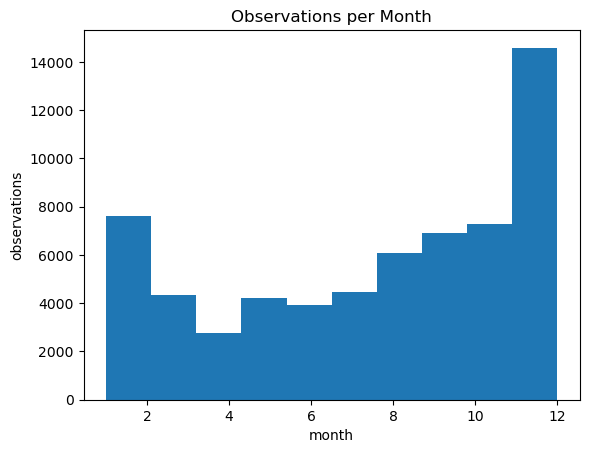

In [16]:
plt.hist(x = data['month'])
plt.xlabel('month')
plt.ylabel('observations')
plt.title('Observations per Month')
plt.show()

We can see that December is clearly the month with most observations. After that comes January. There is also a clear increase in observations starting during August, meaning that at the beginning of the semester there are more observations.

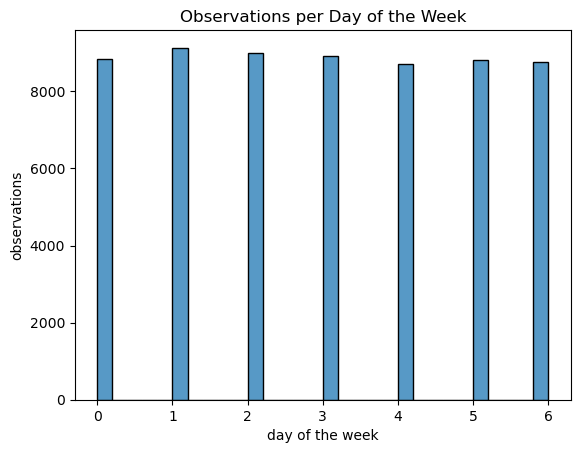

In [6]:
sns.histplot(data['day_of_week'])
plt.xlabel('day of the week')
plt.ylabel('observations')
plt.title('Observations per Day of the Week')
plt.show()

From above we can see that there are no huge differences between each day of the week. Tuesday (day 1) has the highest value, but overall they are all close to each other.

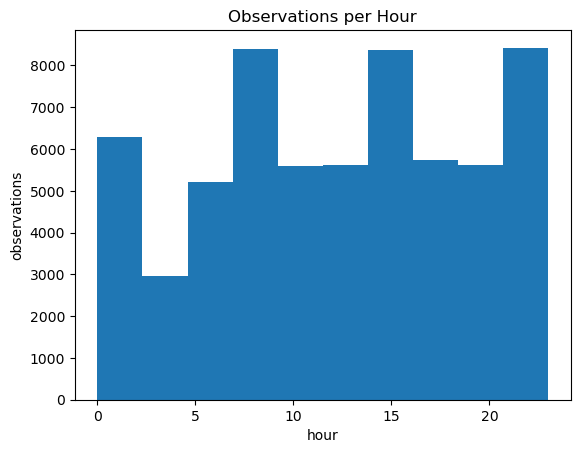

In [7]:
plt.hist(data['hour'])
plt.xlabel('hour')
plt.ylabel('observations')
plt.title('Observations per Hour')
plt.show()

There is a lot more differences between each hour. Before morning (at 3-5) there are a lot less observations than at any other hours. There are also clear spikes at around 9, 15 and 22, meaning that there are a lot of observations. Let's now plot different hours, months and days with `number_people` column.

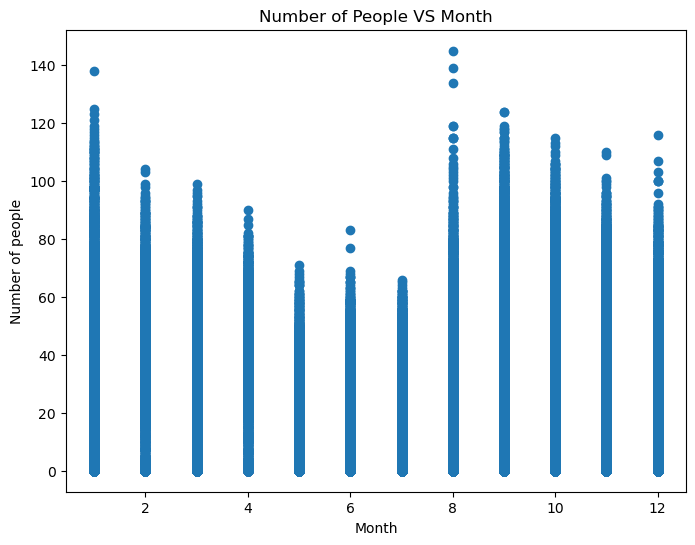

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(data['month'], data['number_people'])
plt.title('Number of People VS Month')
plt.xlabel('Month')
plt.ylabel('Number of people')
plt.show()

August and January are the months with the bigger peaks of people, and again we can see that as the semester begins, the number of people increases.

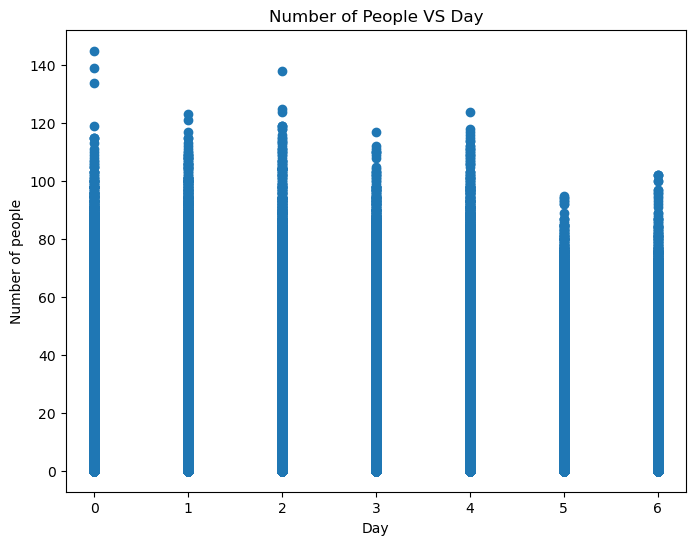

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(data['day_of_week'], data['number_people'])
plt.title('Number of People VS Day')
plt.xlabel('Day')
plt.ylabel('Number of people')
plt.show()

Again different days don't have much differences. Monday has the highest number of people and Saturday has the lowest, but all of them are fairly close to each other.

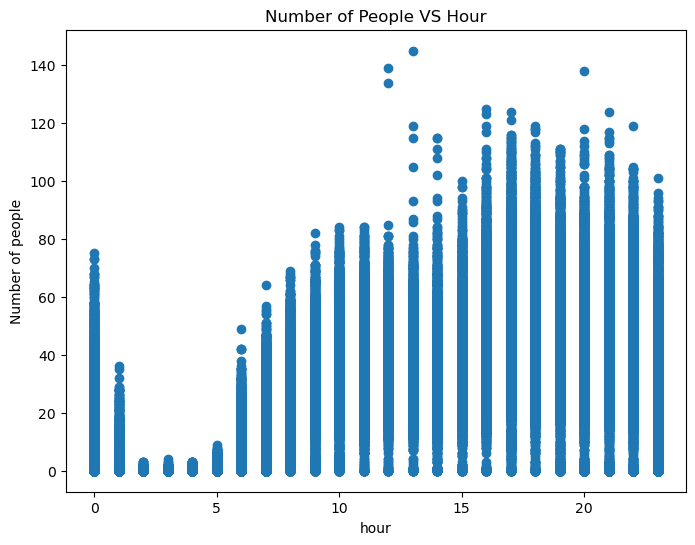

In [10]:
plt.figure(figsize=(8,6))
plt.scatter(data['hour'], data['number_people'])
plt.title('Number of People VS Hour')
plt.xlabel('hour')
plt.ylabel('Number of people')
plt.show()

Different hours have a huge difference. There is barely any people in the gym between 3 to 5, while many other hours have over 100 people. The largest peaks are during afternoon and evening, and there are a lot of people even at night. Let's now look at the correlations.

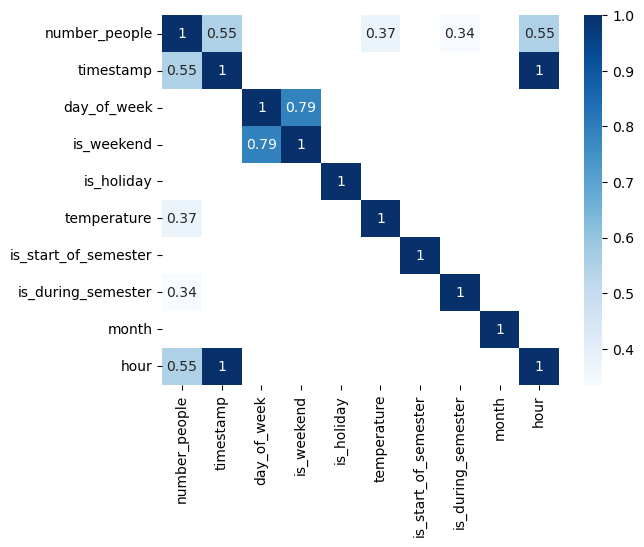

In [11]:
#all columns except date are numerical
corr_data = data.drop(columns='date')
correlations = abs(corr_data.corr())

sns.heatmap(correlations[correlations > 0.3], annot=True, cmap='Blues')
plt.show()

Above is a heatmap that shows the correlation for all the columns that have a correlation over 0.3. We can see that the `number_people` column, which is the outcome we are interested in, correlates with `timestamp` (0.55), `temperature` (0.37), `is_during_semester` (0.34) and `hour` (0.55). `timestamp` and `hour` have the same correlation, and they are almost the same thing (timestamp was the seconds from 00:00, while hour is full hours like "17", so they will correlate the same way). Because of this, we will be using columns `temperature`, `hour` and `is_during_semester` as our features.

## Preparing to Build Our Model

Now that we know which features to use and that our data is clean, we can move on with our model. In this project we are going to use stochastic gradient descent regressor, so let's import all the `SkLearn` libraries required and split our dataset to training and testing sets.

In [12]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

X = data[['hour', 'temperature', 'is_during_semester']]
y = data['number_people']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(49747, 3)
(12437, 3)
(49747,)
(12437,)


Above we created training sets with 49747 observations and testing sets with 12437 observations. Now we will build and train our model.

In [13]:
#scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#model
sgd_1 = SGDRegressor(alpha=0.0001, learning_rate='optimal', loss='huber', penalty='elasticnet', random_state=1)
sgd_1.fit(X_train_scaled, y_train)
y_pred_1 = sgd_1.predict(X_test_scaled)


#measuring performance
mse = mean_squared_error(y_test, y_pred_1)
mae = mean_absolute_error(y_test, y_pred_1)
r_2 = r2_score(y_test, y_pred_1)

print(f"Mean squared error: {mse}, Mean absolute error: {mae}, R2-score: {r_2}")

Mean squared error: 291.90985486277407, Mean absolute error: 12.952235964106045, R2-score: 0.44506139863658145


Mean Squared error and Mean Absolute Error are fairly high (the closer to 0 the better the accuracy is). R2 Score if only 0.45, which is pretty bad - with R2 Score we want it to be as close to 1 as possible. To understand our model's results better let's visualize them.

## Visualizing the Results

To see the differences in our first model, we will create a line plot for our test data and the predictions.

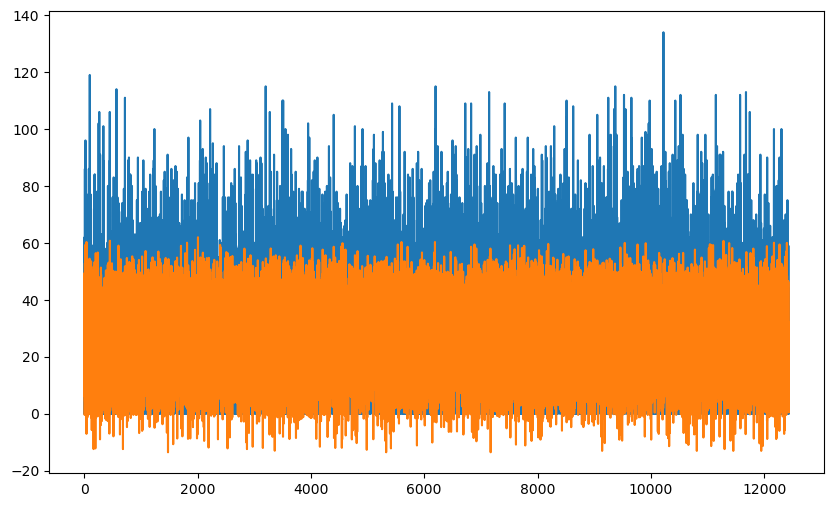

In [14]:
plt.figure(figsize=(10,6))
plt.plot(y_test.values)
plt.plot(y_pred_1)
plt.show()

We can clearly see that there is a lot of room for improvement. The orange color shows our prediction values, the blue color shows the real values. We can see that orange values are much lower than the blue values.

## Trying to Improve Our Model

Let's now try to use all the possible columns with training our model to see if the predictions become more accurate.

In [15]:
X_2 = data.drop(columns=['number_people', 'date'], axis=1)
y_2 = data['number_people']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size = 0.2, random_state=1)

scaler_2 = StandardScaler()
X_train_scaled_2 = scaler_2.fit_transform(X_train_2)
X_test_scaled_2 = scaler_2.transform(X_test_2)


#model
sgd_2 = SGDRegressor(alpha=0.0001, learning_rate='optimal', loss='huber', penalty='elasticnet', random_state=1)
sgd_2.fit(X_train_scaled_2, y_train_2)
y_pred_2 = sgd_2.predict(X_test_scaled_2)

#measuring performance
mse = mean_squared_error(y_test_2, y_pred_2)
mae = mean_absolute_error(y_test_2, y_pred_2)
r_2 = r2_score(y_test_2, y_pred_2)

print(f"Mean squared error: {mse}, Mean absolute error: {mae}, R2-score: {r_2}")

Mean squared error: 264.05714724029195, Mean absolute error: 12.221375415055217, R2-score: 0.49801111018184785


When using all the possible features, we get a little bit better model, but it's still not great. The R2 score is now 0.50 instead of 0.45.

## Summary

In this project we built a model that will help us predict the best time to go to the gym. We used `number_people` as our target variable and `hour`, `temperature`, `is_semester` columns as the predictors. This provided pretty bad model with R2-score of only 0.45.

After that we build a model that used all the columns as features. This gave us a little bit better result, with the R2 score of 0.50.

Stochastic Gradient Descent (SGD) is a good place to start for building a prediction model, but a different algorithm would most likely give us better results. We could also get better performance with changing the hyperparameters (such as learning_rate, loss, penalty etc.). 

While our model is definitely far from perfect, we can see from our data analysis that there are a lot less people at around 5am compared to the afternoon or evening.